# Sentiment Detection in Bangla Text: Building and Analyzing a Multimodal Dataset for Emotion Classification

Emotions are an integral part of human communication, influencing the way we express ourselves and perceive others' messages. In the digital age, the proliferation of social media, online reviews, and text-based communication platforms has led to a massive influx of textual data that encapsulates a diverse range of sentiments. Understanding and accurately categorizing these sentiments, such as happiness, anger, fear, disgust, sadness, and surprise, is not only crucial for improving natural language processing systems but also for gaining insights into human behavior and opinion dynamics.

This thesis project delves into the realm of sentiment analysis for the Bangla language, a significant and vibrant language spoken by millions of people. The objective of this project is to create a comprehensive Bangla sentiment detection dataset encompassing various emotions, allowing for robust sentiment analysis. The dataset's multilingual nature and focus on diverse emotions make it an invaluable resource for researchers, enabling the development of more nuanced and culturally sensitive sentiment classification models.

# Objectives:

# Dataset Construction: 
The first phase of the project involves meticulously curating a diverse and representative dataset that captures different sentiment categories. This dataset encompasses a wide array of Bangla texts, including social media posts, product reviews, and literary excerpts, ensuring the inclusion of both informal and formal language styles.

# Annotation and Categorization: 
The collected dataset will be annotated by human experts proficient in Bangla language and culture. Each text will be categorized into one of the predefined sentiment categories: happy, angry, fear, disgust, sad, or surprise. This categorization will be the foundation for training and evaluating sentiment classification models.

# Model Development: 
The project aims to develop state-of-the-art sentiment classification models specifically tailored for the Bangla language. Leveraging the annotated dataset, these models will employ advanced natural language processing techniques, potentially including pre-trained language embeddings and neural network architectures.

# Performance Evaluation: 
The developed sentiment classification models will undergo rigorous evaluation using various metrics to assess their accuracy, precision, recall, and F1-score. The goal is to create models that not only accurately predict sentiment but also generalize well to real-world Bangla text data.

# Cultural Nuances: 
A significant aspect of this project involves addressing cultural nuances and linguistic intricacies unique to the Bangla language. By developing models that can account for these factors, the sentiment analysis becomes more culturally sensitive and contextually relevant.

# Applications and Implications: 
The outcome of this project extends beyond academic research, with potential applications in various fields, including social media monitoring, market analysis, and customer feedback evaluation. Additionally, insights gained from the analysis of Bangla sentiments can contribute to cross-cultural studies of emotion expression and perception.


# Import Library

In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import chain


# Dataset Load

In [16]:

try:
    with open('corpus_all.txt', 'r', encoding='utf-8') as file:
        lines = []  # Empty list to store the lines
        for line in file:
            lines.append(line.strip())  # Append the line to the list, removing any leading/trailing whitespace
    
    with open('stopwords-bn.txt', 'r', encoding='utf-8') as test:
        stopwords_bn = test.readlines()
        # the above stopwords contains newline \n
        stop_bn = []

        for word in stopwords_bn:
            stop_bn.append(word.rstrip("\r\n"))
            
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")

#file_path = 'corpus_all.txt'  # Replace with the actual path to your text file
first_words = []  # Empty list to store the first words

try:
    for line in lines:
        words = line.strip().split()  # Split the line into words
        if words:
            first_word = words[0]  # Get the first word
            first_words.append(first_word)  # Append the first word to the list

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")


# Define the status levels
status_levels = ["happy","angry","fear","disgust","sad","surprise",]

# Initialize a list to store the extracted status levels and sentences
extracted_data = []

# Iterate over the texts
for text in lines:
    # Initialize variables to store the extracted status level and sentence
    status = ""
    sentence = ""

    # Iterate over the status levels
    for level in status_levels:
        if level in text:
            # Split the text based on the status level
            split_text = text.split(level, 1)

            # Extract the status level and sentence
            status = level
            sentence = split_text[1].strip()
            break

    # Append the extracted status level and sentence to the list
    extracted_data.append({"Status": status, "Sentence": sentence})
    
df = pd.DataFrame(extracted_data)

# Some Data From Dataset

In [17]:
df

,Status,Sentence
0,sad,"বরাবর, মাননীয় প্রধানমন্ত্রী গণপ্রজাতন্ত্রী বা..."
1,sad,তদন্ত করে লাভ কী ? কোন দিন কোন তদন্তের পর কিছু...
2,angry,দেশকি মধ্যম আয়ের দেশে রুপান্তর হচ্ছে নাকি মগের...
3,happy,আমি গর্বিত আমি মুসলিম। আমি সংগ্রামী। আমি যোদ্ধ...
4,angry,রাতের বেলা আবার কিসের সকাল।
...,...,...
6284,surprise,ভারতে প্রতিদিন ১৮ টা রেপ কেইস এন্ট্রি হয়
6285,surprise,এই কি স্বাধীন দেশ
6286,sad,স্বাধীন দেশের নাগরিক হয়ে ও আজ আমরা পরাধীন।
6287,angry,চুদলাম দাদা পয়সা নাই


# Dataset Shape

In [4]:
df.shape

(6289, 2)

# Dataset Status Count Value

In [5]:
df['Status'].value_counts()

happy       1905
angry       1410
sad         1331
disgust      698
surprise     562
fear         383
Name: Status, dtype: int64

In [18]:

def text_pre_processing(text):
    #remove stop words from the text
    text = ' '.join(word for word in text.split() if word not in stop_bn)
    #remove punctuation from the text
    text = re.sub(r'[^\w\s]', '', text)
    #remove numbers from the text
    text = re.sub(r'[0-9]', '', text)
    #remove extra spaces from the text
    text = re.sub(' +', ' ', text)
    return text

df['Sentence'] = df['Sentence'].apply(text_pre_processing)

# Data convert categorical to numerical
df['Status'] = df['Status'].map({'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5})

<Axes: >

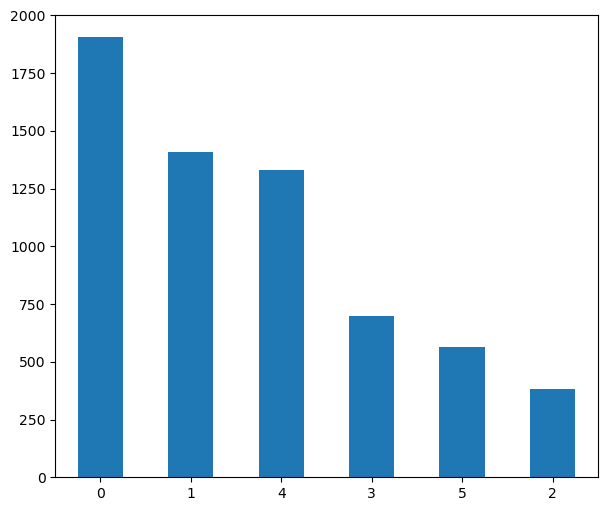

In [19]:
# Plot the distribution of the target variable
df['Status'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)

# Text Pre Processing By Tokenizer Padding Sequences Convert String to Integer And One-Hot Encoded Formet

In [8]:

# Preprocess the text data and convert it to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Sentence'])

sequences = tokenizer.texts_to_sequences(df['Sentence'])

# Padding sequences to the same length
max_length = 100  # Choose an appropriate maximum sequence length
sequences = pad_sequences(sequences, maxlen=max_length)

# Convert labels to lists (from string to integer representation)

label_to_index = {'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}  # Add other labels as needed
labels_indexed = np.array([label_to_index[label] for label in df['Status']])

# Convert labels to one-hot encoded format
num_classes = len(np.unique(labels_indexed))
labels_onehot = to_categorical(labels_indexed, num_classes=num_classes)


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_onehot, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length))
model.add(Conv1D(64, 6, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1992700   
                                                                 
 conv1d_1 (Conv1D)           (None, 95, 64)            38464     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              132000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 2,164,370
Trainable params: 2,164,370
No

In [13]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)


Epoch 1/3


79/79 [==============================] - 51s 511ms/step - loss: 1.6630 - accuracy: 0.3029 - val_loss: 1.6304 - val_accuracy: 0.2973
Epoch 2/3
79/79 [==============================] - 43s 549ms/step - loss: 1.5261 - accuracy: 0.4043 - val_loss: 1.5009 - val_accuracy: 0.4173
Epoch 3/3
79/79 [==============================] - 42s 530ms/step - loss: 1.1355 - accuracy: 0.5915 - val_loss: 1.5897 - val_accuracy: 0.4197


In [15]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

# Make predictions
predictions = model.predict(X_test)

# Convert predictions from one-hot encoded format to label indices
predictions = np.argmax(predictions, axis=1)

# Convert test labels from one-hot encoded format to label indices
y_test = np.argmax(y_test, axis=1)

# Print performance details
print("Accuracy: {0:.2f}%".format(accuracy_score(y_test, predictions) * 100))


Loss: 1.5897040367126465,
Accuracy: 0.4197138249874115
40/40 [==============================] - 9s 73ms/step
Accuracy: 41.97%


In [21]:
# apply smote for imbalanced data set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(df['Sentence'], df['Status'])

# Preprocess the text data and convert it to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resampled)

sequences = tokenizer.texts_to_sequences(X_resampled)

# Padding sequences to the same length
max_length = 100  # Choose an appropriate maximum sequence length
sequences = pad_sequences(sequences, maxlen=max_length)

# Convert labels to lists (from string to integer representation)

label_to_index = {'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}  # Add other labels as needed
labels_indexed = np.array([label_to_index[label] for label in y_resampled])

# Convert labels to one-hot encoded format
num_classes = len(np.unique(labels_indexed))
labels_onehot = to_categorical(labels_indexed, num_classes=num_classes)

#test train split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(sequences, labels_onehot, test_size=0.2, random_state=42)



ValueError: could not convert string to float: 'বরবর মননয পরধনমনতর গণপরজতনতর বলদশ সরকর মননয পরধনমনতর সবপনর ডজটল বলদশর সবপন বক ললনকর একজন ছতর শত সহসর আশ দশর এক অকততম ভলবস নজক দশর যগয গড তলর এক তবর আকঙকষ ভরত হযছলম নজ হত পরতষঠত দশর অনযতম বশববদযলয যশর বজঞন পরযকত বশববদযলয ডজটল বলদশ গডত ধরণর পরযকত বশববদযলয পরতষঠ নসনদহ দশ পরচলনর বচকষণতর পরচয বহন কর যশর বসর সবপনর পরতষঠন শত শত টক বনযগ দহত উজড কর অতযনত দখর সথ বশববদযলয জবনর সচনলগন অনভব করছ য পওযর আননদ শকষরথদর মনপরন উজড পডলখ কথ বপরত কমলমত শকষরথর সদ দনতপত পরণ নশর হমক শললতহনর গলন ছতরতত বতল হমক নয সমমনত শকষকদর মরত যওয গল কট ফলর হমক পরণ নশর হমক কটকত নযমত ঘটন মননয পরধনমনতর শকষরথর শকষকদর পতমতর মত সমমন একজন চতরথ শরণর করমচরর শকষকদর নযমত ঘটনর শকর ডজটল বলদশর সবপন পক হনদর বহনর মত হন যয চখর ছতর বনর সললতহনর হয পরতবদ বহষকর শকষরথদর ভষ আনদলন মকতযদধর বভষকময গলর কথ সশসনর বলদশ আদরশ বশববদযলয বশববদযলযর পরশসনর পষ সনতরস মদক বযবসয শকষকদর লঞচত কর ছতরদর জবন ছনমন খল ছতরদর লঞচত বরল নজর সথপন সবপনর সনর বল গডর সমপরণ পরপনথ মননয পরধনমনতর শকষক শকষরথর মলত আরতনদ যশরর আকশ বতস পরকমপত বসরর বসর একজন করমচর পরশসনর ছতরছযয অনযয পরতকর আজও ন জবনর সনল সময গল কলস পরকষ দয যশর বশববদযলয বনধ সপতহ যবত কতটক সময পরল সরয দখব শকষক লঞচত হল ছতর লঞচত হল ছতরদর জবন বপনন সহযয পব অনগরহ সবপন গল বচত এগয আসন সদষটর পথ পন গনছ আমর বনত ম নসর উদদন বদল জন পরকশল জব পরযকত বভগ যশর বজঞন পরযকত বশববদযলয'

# Create A Bi - LSTM Model

In [13]:

# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the unknown token

# Define the embedding dimension
embedding_dim = 100  # Set an appropriate value for the word embedding dimension

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(200, kernel_size=3, activation="tanh"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='tanh'))
model.add(Flatten())
model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01), activation="tanh"))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


# Fit Dataset this model

In [14]:

# Train the model
model.fit(sequences, labels_onehot, epochs=5)


Epoch 1/5
197/197 [==============================] - 189s 876ms/step - loss: 2.0131 - accuracy: 0.3530
Epoch 2/5
197/197 [==============================] - 162s 823ms/step - loss: 1.4350 - accuracy: 0.5328
Epoch 3/5
197/197 [==============================] - 183s 925ms/step - loss: 0.9897 - accuracy: 0.6726
Epoch 4/5
197/197 [==============================] - 151s 763ms/step - loss: 0.7231 - accuracy: 0.7456
Epoch 5/5
197/197 [==============================] - 145s 735ms/step - loss: 0.5411 - accuracy: 0.8167


# Accuracy And Confusion Matrix

In [16]:

# Make predictions on the data
y_pred = model.predict(sequences)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(labels_indexed, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_indexed, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Generate the classification report
print("Classification Report:")
print(classification_report(labels_indexed, y_pred_classes))

197/197 [==============================] - 43s 200ms/step
Accuracy: 0.8629352838289076
Confusion Matrix:
[[1896    5    2    0    2    0]
 [  12 1369    0   19    4    6]
 [ 118    1  195    0   66    3]
 [   3   56    0  521   28   90]
 [  27    5  134   16 1108   41]
 [   1    5    3  110  105  338]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1905
           1       0.95      0.97      0.96      1410
           2       0.58      0.51      0.54       383
           3       0.78      0.75      0.76       698
           4       0.84      0.83      0.84      1331
           5       0.71      0.60      0.65       562

    accuracy                           0.86      6289
   macro avg       0.80      0.78      0.79      6289
weighted avg       0.86      0.86      0.86      6289



# Confusion Matrix Chart

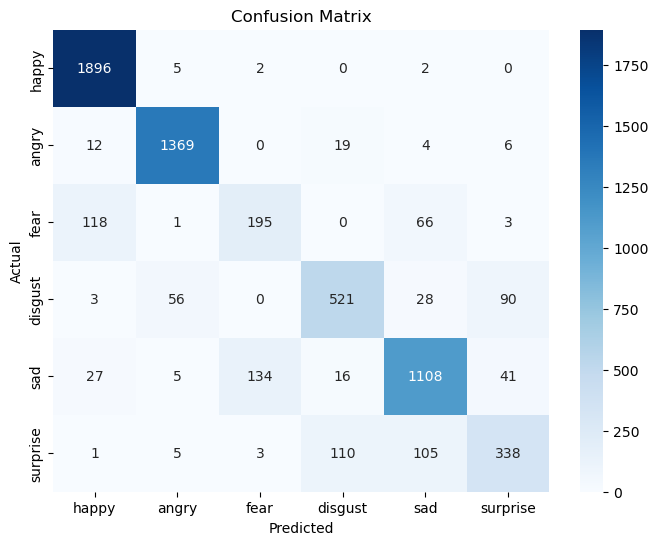

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_indexed, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ... (remaining code)


# ROC Curve

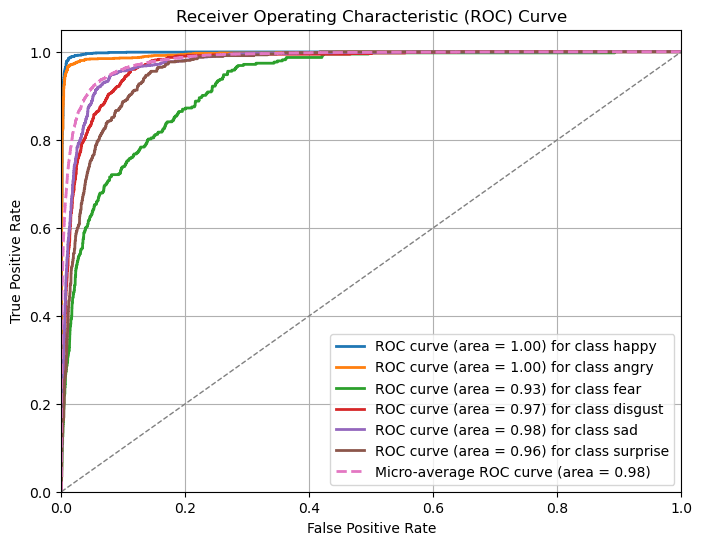

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], label_to_index[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', lw=2)

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [65]:

# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the unknown token

# Define the embedding dimension
embedding_dim = 100  # Set an appropriate value for the word embedding dimension

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(200, kernel_size=3, activation="tanh"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='tanh'))
model.add(Flatten())
model.add(Dense(100, kernel_regularizer=regularizers.l2(0.01), activation="tanh"))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
model.fit(sequences, labels_onehot, epochs=5)

# Make predictions on the data
y_pred = model.predict(sequences)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_indexed, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Generate the classification report
print("Classification Report:")
print(classification_report(labels_indexed, y_pred_classes))


Epoch 1/5
197/197 [==============================] - 156s 689ms/step - loss: 1.9885 - accuracy: 0.3584
Epoch 2/5
197/197 [==============================] - 137s 694ms/step - loss: 1.4372 - accuracy: 0.5297
Epoch 3/5
197/197 [==============================] - 137s 694ms/step - loss: 1.0047 - accuracy: 0.6678
Epoch 4/5
197/197 [==============================] - 143s 727ms/step - loss: 0.7245 - accuracy: 0.7559
Epoch 5/5
197/197 [==============================] - 41s 196ms/step
Confusion Matrix:
[[1888    3    0    2   12    0]
 [   5 1354    0   13   13   25]
 [   6    3    0  145  215   14]
 [   1    8    0  535   56   98]
 [   9    3    0   38 1269   12]
 [   0    8    0   74   19  461]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1905
           1       0.98      0.96      0.97      1410
           2       0.00      0.00      0.00       383
           3       0.66      0.77      0.71       698
         

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
label_to_index = {0: 'happy', 1: 'angry', 2: 'fear', 3: 'disgust', 4: 'sad', 5: 'surprise'}


happy


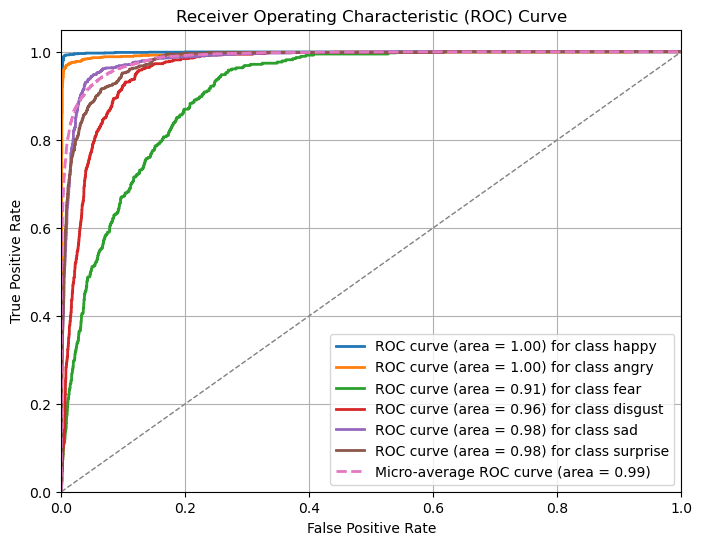

In [70]:
# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], label_to_index[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"], linestyle='--', lw=2)

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()